In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Bayesian Models

# 1. Fitting models & working with multiple observations

In demographic studies of extragalactic stellar sources, often we describe the populations as a function of host galaxy properties. This is a way to study  *ultraluminous X-ray sources* which are predominantly young X-ray binaries where a compact object (neutron star or black hole) accretes matter from the companion (a main-sequence or evolved star) at super-Eddington rates. Because of their short lifetimes, they are found in galaxies that are forming new stars intensly, namely, with high star-formation rate. Let's see if how we can fit the scaling factor between the star-formation rate and the number of ULXs:

$$\Large N_{\text{ULX}} = a \frac{\text{SFR}}{1\rm\,M_\odot\,yr^{-1}} $$

In lin-space: y = 10.16 x + 0.7702
In log-space: y = 10.54 x ^ 0.9841
The fraction: y = 10.29


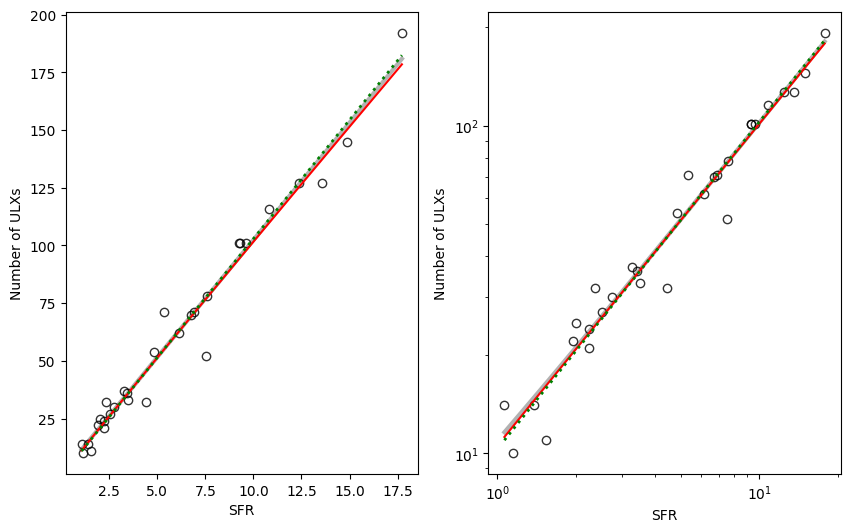

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_galaxies = 30
SFRs = 10.0 ** np.random.uniform(0, 1.3, size=n_galaxies)
a_true = 10          # change with 0.5... what is the problem with the fit in log-space?
n_ULXs = np.random.poisson(a_true * SFRs)

slope, interc = np.polyfit(x=SFRs, y=n_ULXs, deg=1)
slope_log, interc_log = np.polyfit(x=np.log10(SFRs), y=np.log10(n_ULXs), deg=1)
slope_mle = sum(n_ULXs) / sum(SFRs)

xx = np.linspace(min(SFRs), max(SFRs), 100)
yy = slope * xx + interc
yy_log = 10.0 ** (slope_log * np.log10(xx) + interc_log)
yy_mle = slope_mle * xx

sign = "+" if interc >= 0 else "-"

print(f"In lin-space: y = {slope:.4g} x {sign} {abs(interc):.4g}")
print(f"In log-space: y = {10.0**interc_log:.4g} x ^ {slope_log:.4g}")
print(f"The fraction: y = {slope_mle:.4g}")


plt.figure(figsize=(10, 6))
for inlog, subplot in zip([False, True], [1, 2]):
    plt.subplot(1, 2, subplot)
    plt.plot(SFRs, n_ULXs, "ko", mfc="None", alpha=0.8)
    plt.plot(xx, yy, "k-", lw=3, alpha=0.3)
    plt.plot(xx, yy_log, "r-")
    plt.plot(xx, yy_mle, "g:", lw=2)
    plt.xlabel("SFR")
    plt.ylabel("Number of ULXs")
    if inlog:
        plt.loglog()
plt.show()

We have measurements of the number of ULXs, 
$$\large \{n_i\} = \{n_1, n_2, \cdots, n_N\}$$
and the star-formation rates 
$$\large \{s_i\} = \{s_1, s_2, \cdots, s_N\}$$
for $N$ galaxies.

We expect them to scale with $a$ as the scaling factor and we want to find its value. 

$$\large n_i \approx a s_i $$

However, it is not an equality because in reality, the number of XRBs is Poisson-distributed. The expression could only connect the average number of XRBs in a galaxy as a function of its SFR. The observed value is just following this distribution (if our model is correct):

$$\large n_i \sim \text{Pois}(a s_i) $$

Then the posterior of the scaling factor is:

$$\large 
\begin{align}
        & P(\text{parameters} | \text{data}) = &\quad\text{(for our problem...)}
    \\ =& P(a | \{n_i\} \{s_i\}) = &\quad \text{(apply Bayes' formula)}
    \\ =& P(\{n_i\} | a, \{s_i\}) P(a) = &\quad \text{(break it down to all data/param.)}
    \\ =& P(n_1, n_2, n_3, \cdots n_N | a, s_1, s_2, s_3, \cdots s_N) P(a) &\quad \text{(assume independent data)}
    \\ =& \left[P(n_1 | a, s_1, s_2, s_3, \cdots s_N) \times P(n_2 | a, s_1, s_2, s_3, \cdots s_N) \cdots \right] P(a) = &\quad\text{(but $n_{i\neq j}$ doesn't depend on $s_j$)}
    \\ =& \left[P(n_1 | a, s_1) \times P(n_2 | a, s_2) \cdots P(n_N | a, s_N) \right] P(a) = &\quad\text{(a product of likelihoods...)}
    \\ =& P(a) \prod_{i=1}^{N} P(n_i | a, s_i) = P(a) \prod_{i=1}^{N} L_i
\end{align}
$$

where 

$$\large
L_i = P(n_i | a, s_i)
$$

is the $i$-th **datum likelihood**: the likelihood of the $i$-th datapoint given the value of the parameter. Datum likelihoods are only useful (as shortcuts) if the datapoints are independent. Usually, when people write down their Bayesian analysis, they often take this for granted and start directly from the above equation for the posterior.

Therefore, for our problem we can simply state:

$$\large P(a | \{n_i\} \{s_i\}) = P(a) \prod_{i=1}^{N} L_i $$

where $P(a)$ is the prior which we chose to be uniform, allowing only positive values for the scaling factor, and the datum likelihood is the PMF of the Poisson distribution with mean value equal to $a s_i$ evaluated at $n_i$:

$$\large
L_i = P(n_i | a, s_i) = \text{Pois}(n_i; a s_i) = \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!}
$$

In [5]:
import scipy.stats as st

def prior(scaling_factor):
    return 0.0 if scaling_factor < 0 else 1.0

def datum_likelihood(nulx, sfr, scaling_factor):
    return st.poisson.pmf(nulx, sfr * scaling_factor)

def likelihood(nulx_array, sfr_array, scaling_factor):
    return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
                    for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def posterior(scaling_factor, nulx_array, sfr_array):
    return likelihood(nulx_array, sfr_array, scaling_factor) * prior(scaling_factor)

a_values = np.linspace(a_true / 2.0, a_true * 2.0, 1000)
P_values = np.array([posterior(scaling_factor=a, nulx_array=n_ULXs, sfr_array=SFRs) for a in a_values])

# now try with 100 data points

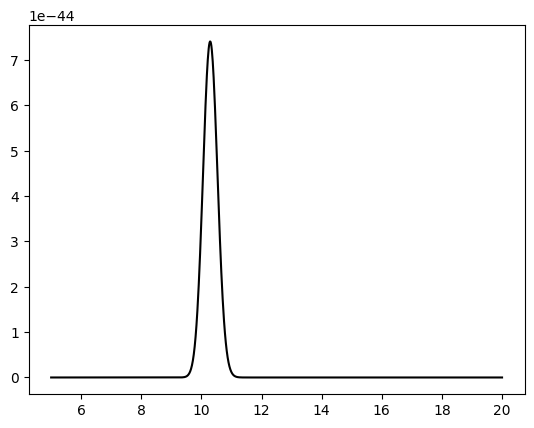

In [6]:
plt.figure()
plt.plot(a_values, P_values, "k-")
plt.show()

* Do the same computation, but this time change the `a_true` to 0.5. What is the problem?
* Do the same computation, but this time use 100 data points. What is the problem?
* What if we wanted to find the optimal value, i.e. where is the maximum of the posterior?

$$\large 
\frac{\partial}{\partial a} P(a | \{n_i\} \{s_i\}) = 0 
\Rightarrow 
\frac{\partial}{\partial a} P(a) \prod_{i=1}^{N} \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!} = 0 $$

# Working in log-space

When we are computing likelihoods and posteriors, we often explore regions where the model is improbable, and the quantities tend to zero. Also, with many data points, the product of the datum likelihoods becomes smaller and smaller, and often evaluates to zero!

In addition, differentiating the posterior (analytically or numerically) might be difficult if there is a significant peak.

Working in log-space alleviates all the above issues! The bell-like peaks become parbolas, the probabilities are now negative values with small absolute values. So the **log-posterior** is

$$\large
\ln \large P(a | \{n_i\} \{s_i\}) = \ln P(a) + \sum_{i=1}^{N} \ln L_i
$$

the sum of the **log-prior** and the **log-likelihood**, the latter being the sum of all **datum log-likelihoods**.

It's so useful, and more accurate to work in log-space, that most `scipy` statistical distributions have their log-analogs (e.g, `st.poisson.logpmf(...)`) that are optimized to give more accurate results than log-ing the original function.

Therefore, we can re-write the functions in their log-versions:

In [7]:
def ln_prior(scaling_factor):
    # return 0.0 if scaling_factor < 0 else 1.0
    return -np.inf if scaling_factor < 0 else 0.0

def datum_ln_likelihood(nulx, sfr, scaling_factor):
    # return st.poisson.pmf(nulx, sfr * scaling_factor)
    return st.poisson.logpmf(nulx, sfr * scaling_factor)

def ln_likelihood(nulx_array, sfr_array, scaling_factor):
    # return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
    #                for nulx_i, sfr_i in zip(nulx_array, sfr_array)])
    return np.sum([datum_ln_likelihood(nulx_i, sfr_i, scaling_factor)
                   for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def ln_posterior(scaling_factor):
    return ln_likelihood(n_ULXs, SFRs, scaling_factor) + ln_prior(scaling_factor)

lnP_values = np.array([ln_posterior(scaling_factor=a) for a in a_values])

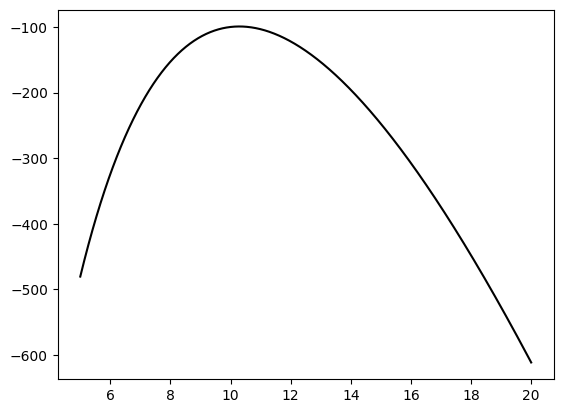

In [8]:
plt.figure()
plt.plot(a_values, lnP_values, "k-")
plt.show()

# Minimization as a means to get the Maximum a Posteriori (MAP) estimate

The parameter value at which the posterior is maximized is an estimate for the true value of the parameter. The maximum a posteriori estimate can be found using optimization techniques. Many algorithms have been implemented to do this for us (for example in the `scipy` package). Traditionally the search for the minimum in a function. Therefore, we proceed by negating the log-posterior. Let's try that!

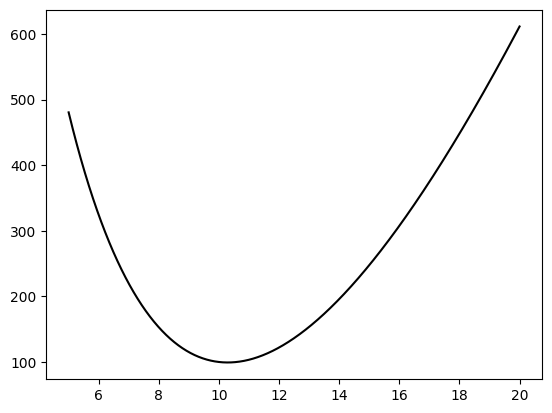

MAP estimate for a = 10.29


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 99.31049198317774
       x: [ 1.029e+01]
     nit: 8
     jac: [-1.526e-05]
    nfev: 20
    njev: 8

In [10]:
from scipy.optimize import minimize

def neg_ln_posterior(scaling_factor):
    return -ln_posterior(scaling_factor)

plt.figure()
plt.plot(a_values, [neg_ln_posterior(ai) for ai in a_values], "k-")
plt.show()

# TNC, SLSQP, Powell, trust-constr
minimization_result = minimize(neg_ln_posterior,  x0=1.0, method="SLSQP", bounds=[[0.0, 20.0]], tol=1.0e-12)
print(f"MAP estimate for a = {minimization_result.x[0]:.4g}")
minimization_result

# Getting the uncertainty on the parameter using the shape of the posterior

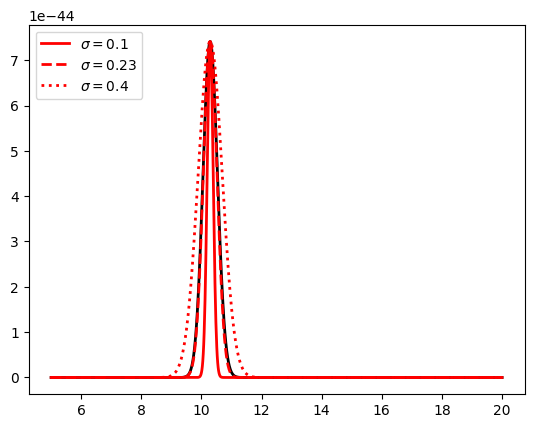

In [11]:
a_MAP = minimization_result.x[0]
P_at_a_MAP = posterior(a_MAP, nulx_array=n_ULXs, sfr_array=SFRs)
sigmas = [0.1, 0.23, 0.4]

plt.figure()
plt.plot(a_values, P_values, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, P_at_a_MAP * np.exp(-(a_values-a_MAP)**2.0 / (2*sigma**2.0)), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="upper left")
plt.show()

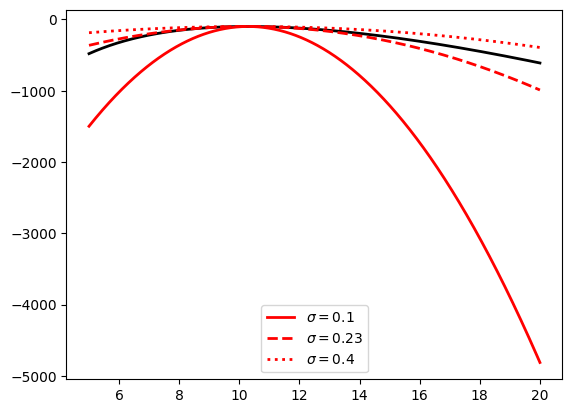

In [12]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values), "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, lnP_at_a_MAP - (a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="lower center")
plt.show()

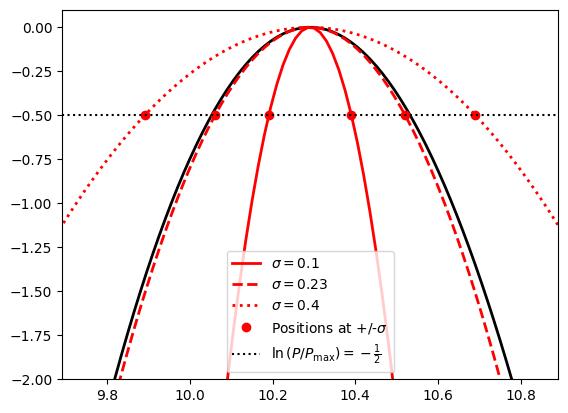

In [13]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values) - lnP_at_a_MAP, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, -(a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
    for offset_in_sigmas in [-1, 1]:
        plt.plot(a_MAP + offset_in_sigmas * sigma, -(offset_in_sigmas * sigma)**2.0 / (2*sigma**2.0), "ro")
plt.plot([], [], "ro", label="Positions at +/-$\sigma$")
plt.axhline(-0.5, color="k", ls=":", label=r"$\ln\left(P / P_{\max}\right)=-\frac{1}{2}$")
plt.legend(loc="lower center")
plt.xlim(a_MAP - 0.6, a_MAP + 0.6)
plt.ylim(-2.0, 0.1)
plt.show()

MAP = 10.291 +/- 0.240 ... from the solutions: 10.052 and 10.533


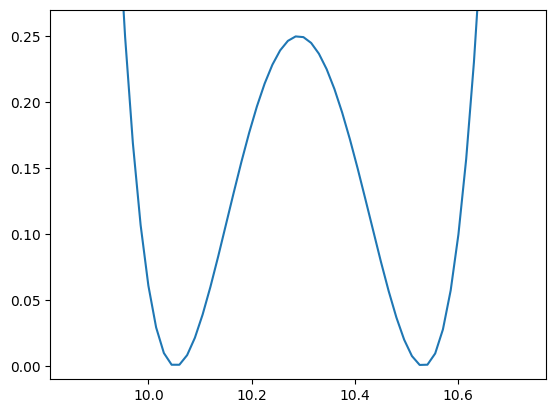

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 3.544925204007213e-08
        x: [ 1.005e+01]
      nit: 10
      jac: [-1.593e-03]
     nfev: 20
     njev: 10,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: 7.300388084172153e-10
        x: [ 1.053e+01]
      nit: 13
      jac: [ 2.218e-04]
     nfev: 28
     njev: 13)

In [15]:
solution_left = minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP / 2.0, method="SLSQP", bounds=[[0.0, a_MAP*0.999]])
solution_right = minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP * 2.0, method="SLSQP", bounds=[[a_MAP*1.001, np.inf]])

a_lo = solution_left.x[0]
a_hi = solution_right.x[0]
a_err = (a_hi - a_lo) / 2.0
print(f"MAP = {a_MAP:.3f} +/- {a_err:.3f} ... from the solutions: {solution_left.x[0]:.3f} and {solution_right.x[0]:.3f}")

plt.figure()
xx = a_values
yy = [(ln_posterior(xxi) - lnP_at_a_MAP + 0.5)**2.0 for xxi in xx]
plt.plot(a_values, yy)
plt.xlim(a_MAP - 2*a_err, a_MAP + 2*a_err)
plt.ylim(-0.01, 0.27)
plt.show()

solution_left, solution_right

# Hypothesis Testing and Model Selection: Freq. vs. Bays.

> Science is more than a body of knowledge; it is a way of thinking.
> The method of science, as stodgy and grumpy as it may seem,
> is far more important than the findings of science. — Carl Sagan

In [33]:
# TODO: change `scale` to `width`...

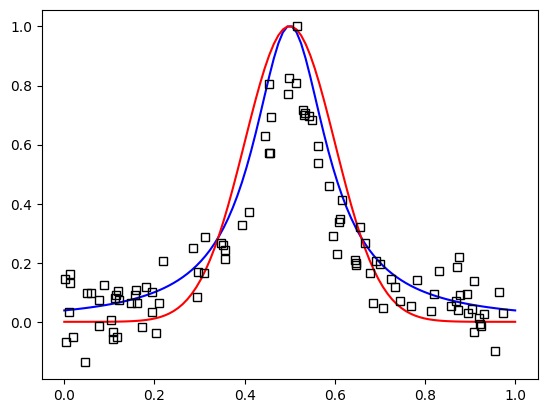

In [16]:
def make_data(x, model_dist, amplitude, location, scale, error_scale=0.0):
    distribution = model_dist(loc=location, scale=scale)
    y = distribution.pdf(x)
    y *= amplitude / distribution.pdf(location)
    if error_scale > 0:
        y = np.random.normal(y, scale=error_scale)
    return y

x_plot = np.linspace(0, 1, 100)
y1_plot = make_data(x_plot, st.cauchy, amplitude=1.0, location=0.5, scale=0.1)
y2_plot = make_data(x_plot, st.norm, amplitude=1.0, location=0.5, scale=0.1)

model_distributions = [st.cauchy, st.norm]

n_data = 100
true_location = 0.5
true_model_distribution = model_distributions[31337 % 17 % 2]
true_error_scale = 0.1
x_data = np.sort(np.random.uniform(size=n_data))
y_data = make_data(x_data, true_model_distribution, amplitude=1.0, location=0.5, scale=0.1, error_scale=true_error_scale)
y_data /= y_data.max()
y_data

plt.figure()
plt.plot(x_plot, y1_plot / y1_plot.max(), "b-")
plt.plot(x_plot, y2_plot / y2_plot.max(), "r-")
plt.plot(x_data, y_data, "ks", mfc="none")
plt.show()

In [17]:
def likelihood(x_data, y_data, model_dist, amplitude, location, scale):
    y_pred = make_data(x_data, model_dist=model_dist, amplitude=amplitude, location=location, scale=scale)
    return np.exp(np.sum(-(y_data - y_pred)**2.0))

# loglike1 = sum(-(y_data - make_data(x_data, st.cauchy, amplitude=1.0, location=0.5, scale=0.1))**2.0)
# loglike2 = sum(-(y_data - make_data(x_data, st.norm, amplitude=1.0, location=0.5, scale=0.1))**2.0)
like1 = likelihood(x_data, y_data, st.cauchy, amplitude=1.0, location=0.5, scale=0.1)
like2 = likelihood(x_data, y_data, st.norm, amplitude=1.0, location=0.5, scale=0.1)
print(like1 / like2)

2.344483018691325


# The frequentist approach: least-squares model fitting and the reduced chi-square statistic

In [18]:
def reduced_chi_square(x_data, y_data, model_dist, amplitude, location, scale, error_scale, model_dof):
    y_pred = make_data(x_data, model_dist=model_dist, amplitude=amplitude, location=location, scale=scale)
    return np.sum(((y_data - y_pred) / error_scale)**2.0) / (len(x_data) - model_dof)

chi2_1 = reduced_chi_square(x_data, y_data, st.cauchy, amplitude=1.0, location=0.5, scale=0.1, error_scale=true_error_scale, model_dof=0.0)
chi2_2 = reduced_chi_square(x_data, y_data, st.norm, amplitude=1.0, location=0.5, scale=0.1, error_scale=true_error_scale, model_dof=0.0)

print(chi2_1, chi2_2)

1.1553975832858758 2.0074624997665538


## Akaike Information Criterion

When the model describes our system, then the residuals will be essentially a random noise. Nothing can be extracted out of the residuals, except for their "scale". E.g.,:

* when we fit polynomial to our data and the residuals have "structure", we suspect we need either a different functional form, or additional degrees for the polynomial.
* when we subtract starlight in astronomical images (source detection, masking the sources, etc.), sometimes we see residuals or stars that haven't been removed and redo the process with different parameters.

A good model reduces the information we can extract from a system, or... it maximizes its entropy! The AIC is the application of the Second Law of Thermodynamics on statistics using information theory (cf. Shannon's information entropy).

In [19]:
AIC_1 = 2 * 0 - 2 * np.log(like1)
AIC_2 = 2 * 0 - 2 * np.log(like2)
print(AIC_1, AIC_2)

2.3107951665717517 4.0149249995331076


# What if we don't know one (or more) of the parameters of the models?

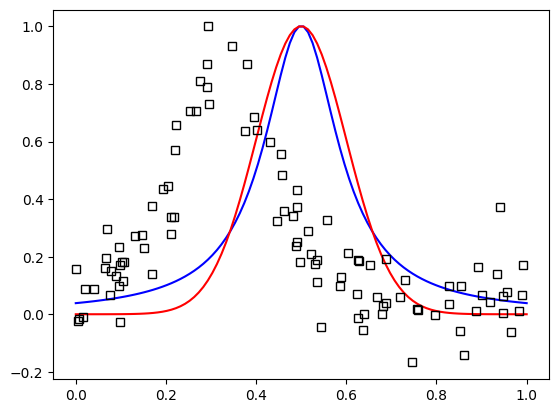

In [20]:
n = 100
true_location = np.random.uniform(0.3, 0.7)
true_model_distribution = model_distributions[31337 % 17 % 2]
error_scale = 0.1
x_data = np.sort(np.random.uniform(size=100))
y_data = make_data(x_data, true_model_distribution, amplitude=1.0, location=true_location, scale=0.1, error_scale=error_scale)
y_data /= y_data.max()
y_data

plt.figure()
plt.plot(x_plot, y1_plot / y1_plot.max(), "b-")
plt.plot(x_plot, y2_plot / y2_plot.max(), "r-")
plt.plot(x_data, y_data, "ks", mfc="none")
plt.show()

# We could fit the models, and compare the likelihoods. AIC and BIC as well...

In [22]:
def func_to_minimize(location, model_dist):
    return -np.log(likelihood(x_data=x_data, y_data=y_data, model_dist=model_dist, amplitude=1.0, location=location, scale=0.1))

minimization_result_1 = minimize(func_to_minimize,  x0=0.5, method="SLSQP", bounds=[[0.0, 1.0]], tol=1.0e-12, args=(st.cauchy))
minimization_result_2 = minimize(func_to_minimize,  x0=0.5, method="SLSQP", bounds=[[0.0, 1.0]], tol=1.0e-12, args=(st.norm))
location_1 = minimization_result_1.x[0]
location_2 = minimization_result_2.x[0]

print("Locations:", location_1, "and", location_2)

like1 = likelihood(x_data=x_data, y_data=y_data, model_dist=st.cauchy, amplitude=1.0, location=location_1, scale=0.1)
like2 = likelihood(x_data=x_data, y_data=y_data, model_dist=st.norm, amplitude=1.0, location=location_2, scale=0.1)

AIC_1 = 2 * 1 - 2 * np.log(like1)
AIC_2 = 2 * 1 - 2 * np.log(like2)
BIC_1 = 2 * 1 * np.log(n_data) - 2 * np.log(like1)
BIC_2 = 2 * 1 * np.log(n_data) - 2 * np.log(like2)
print("AIC:", AIC_1, AIC_2)
print("BIC:", BIC_1, BIC_2)
print("BF:", like1/like2)

Locations: 0.3294727320437909 and 0.33174372705675176
AIC: 3.8893202082715983 4.637018457599059
BIC: 11.099660580247782 11.847358829575242
BF: 1.4533178640933653


## Do you see any problem with fitting before comparing the models?
### TODO: some of these will be moved above since I added new blocks

* Extra trouble: fitting a model is another process that has its own caveats and peculiarities
* If one of the models is flexible enough (e.g., an n-degree polynomial) it would fit the data better due to its flexibility, rather than its representability of real observations.
* Any inference from the model comparison is conditional to the fitting results

In [23]:
from scipy.integrate import quad
def likelihood_uknown_location(x_data, y_data, model_dist, amplitude, scale):
    def func(loc):
        return likelihood(x_data=x_data, y_data=y_data, model_dist=model_dist, amplitude=amplitude, location=loc, scale=scale)
    
    return quad(func, 0.0, 1.0)[0]

like1_margin = likelihood_uknown_location(x_data, y_data, model_dist=st.cauchy, amplitude=1.0, scale=0.1)
like2_margin = likelihood_uknown_location(x_data, y_data, model_dist=st.norm, amplitude=1.0, scale=0.1)
print(like1_margin / like2_margin)

1.6030440187043733


# References

[1] D. S. Sivia, J. Skilling (2006). Data Analysis: A Bayesian Tutorial. 2nd Edition. Oxford University Press.